# Cluster Analysis

### Import modules

In [1]:
# General
import os
import sys
import re

# Data handling
import pandas as pd
import numpy as np

# Data Science
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import shap

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# MD
import MDAnalysis as mda
import nglview as nv

In [2]:
# Move wd to project root
os.chdir('/home/amorales/Documents/projects/bias_2')

# Import utils modules
sys.path.append('src/utils')
from get_BW_nomenclature import get_bw
sys.path.append('src/models')
from utils import StratifiedGroupKFold, get_sample_balanced_weight

## Load Data

In [24]:
# Move wd to project root
df = pd.read_csv('data/processed/features_new.csv', index_col=0)
df.mutant_id = df.mutant_id.astype(str)

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


## Process data

In [25]:
# Separate Features and labels
contact_columns = [col for col in df.columns if '-' in col]
X = df[contact_columns]
y = df.profile
group = df.mutant_id

In [26]:
# Filter Contacts happening in the receptor core
u = mda.Universe('data/interim/aligned_sims/WT/structure.psf','data/interim/wt.pdb')
core = u.select_atoms('protein and name CA  and (prop z > 80) and (prop z < 115)')
core_resids = [str(resid) for resid in core.atoms.resids]

core_contacts = []
for col in X.columns:
    if len(set(col.split('-')) & set(core_resids)) == 2:
        core_contacts.append(col)
        
X = X[core_contacts]

In [27]:
# Remove Features with low variability
# X = X.loc[:, (X.std() > 0.15).values.flatten()]

In [28]:
# Remove residues with high correlation
def get_low_corr_df(df, max_corr):
    """Generates a dataframe without high correlated features

    Args:
        df (pandas.DataFrame): dataframe holding features and optionally labels, and groups
        feature_cols (list): a list holding the column names of df that correspond to features
        max_corr (float): Scalar between 0 and 1 that defines the max correlation present in clean_df and used to build the correlation dictionary

    Returns:
        clean_df (pandas.DataFrame): DataFrame holding a version of df with a max correlation below max_corr
        corr_dict (dict): Dictionary relating one feature to all the residues with a correlation higher than max_corr
        
    """
    
    real_corr_matrix = df.corr()
    abs_corr_matrix = real_corr_matrix.abs()
    # Extract the upper trinagule from the correlation matrix
    upper = abs_corr_matrix.where(
        np.triu(np.ones(abs_corr_matrix.shape),  k=1).astype(np.bool))
    # Remove redundant features with a correlation higher than max_corr
    to_drop = [column for column in upper.columns if any(upper[column] > max_corr)]
    clean_df = df.drop(to_drop, axis=1)
    
    # Generate correlation dict
    corr_dict = {}
    for feat in df.columns:
        
        # get a mask for features highly correlated to feat 
        high_corr_mask = abs_corr_matrix[str(feat)] > max_corr
        
        # Get the column names corresponding to those features
        cols = real_corr_matrix.columns[high_corr_mask]
        
        # link feat and the set of columns in the correlation dict
        corr_dict[feat] = cols
    
    return clean_df, corr_dict

X, corr_dict = get_low_corr_df(X, 0.8)

In [29]:
# Remove interactions between residues close in the sequence
res_dist_list = []

for contact in X.columns:
    r1, r2 = map(int, contact.split('-'))
    
    diff = abs(r1 - r2)
    res_dist_list.append(diff)
    
res_dist_list = np.array(res_dist_list)
# Create a mask for filtering interactions between residues separated in the sequence
sep_res_mask = res_dist_list > 4
X = X.loc[:, sep_res_mask]


In [30]:
# # Keep only conserved domains interacionts
# micro_switch_dict = {'dry': range(130, 133),
#                 'npxxy': range(295, 300),
#                 'cwp': range(257, 261),
#                 'pif': [121, 201, 254],
#                 'sod_bs': [80, 120, 291, 292],
#                 'toogle_s': [258],
#                 '6.30': [240]}

# ms_resids = [str(resid) for ms in micro_switch_dict.values() for resid in ms]
# ms_contacts = [contact for contact in X.columns if set.intersection(set(ms_resids), set(contact.split('-')))]

# X = X[ms_contacts]

## PCA analysis

In [31]:
n_comp = 10
pca = PCA(n_components=n_comp)

In [45]:
pca_df = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_df, columns=[f'pc{i}' for i in range(1, n_comp+1)])
pc_X = pca_df.copy()
pca_df[['mutant_id', 'replica', 'profile']] = df[['mutant_id', 'replica', 'profile']].reset_index(drop=True)

In [46]:
# for i in range(1,n_comp+1):
#     for j in range(1,n_comp+1):
#         c1 = f"pc{i}"
#         c2 = f"pc{j}"
        
#         # plt.figure(dpi=300)
#         sns.scatterplot(data=pca_df, x=c1, y=c2, hue='profile')
#         sns.scatterplot(data=pca_df[pca_df.mutant_id == 'wt'], x=c1, y=c2, color='red')
        
#         plt.show()

## Fit the data

In [47]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

In [50]:
features = pc_X
score_df = []
for c in np.linspace(0, 2, 1000):
    
    clf = SVC(kernel='rbf', C=c, class_weight='balanced')
    # clf = LogisticRegression(C=c, class_weight='balanced')
    kf = GroupKFold(n_splits=5, )

    
    for train_index, test_index in kf.split(features, y, groups=group, ):
        X_train, X_test = features.values[train_index], features.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        
        # score = f1_score(y_test, pred)
        sample_weight, class_weight = get_sample_balanced_weight(y_test)
        score = accuracy_score(y_test, pred, sample_weight=sample_weight)
       
        score_df.append([c, score])
        
score_df = pd.DataFrame(score_df, columns = ['c', 'score'])

ValueError: C <= 0

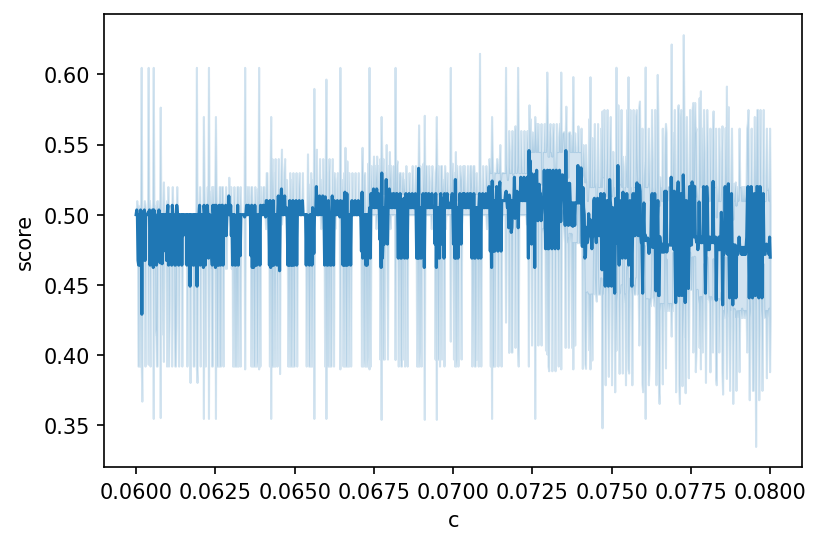

In [49]:
plt.figure(dpi=150)
sns.lineplot(data=score_df, x='c', y='score')
plt.show()

In [99]:
pd.DataFrame(score_df.groupby('c').score.mean()).sort_values('score')

,score
c,
0.061922,0.448333
0.060060,0.448333
0.061221,0.448333
0.061822,0.448333
0.062482,0.448333
...,...
0.067267,0.721667
0.062583,0.721667
0.063283,0.721667


In [102]:
clf = SVC(kernel='rbf', C=0.067267, class_weight='balanced')
    # clf = LogisticRegression(C=c, class_weight='balanced')
kf = GroupKFold(n_splits=5, )

for train_index, test_index in kf.split(features, y, groups=group, ):
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    # score = f1_score(y_test, pred)
    sample_weight, class_weight = get_sample_balanced_weight(y_test)
    score = accuracy_score(y_test, pred, sample_weight=sample_weight)
    
    print(score)

0.5000000000000001
0.6250000000000001
0.5833333333333333
0.65
1.0


In [101]:
baseline_score = score
baseline_score

0.5000000000000001

In [ ]:
permuted_X = X.copy()
permutation_indices = np.random.permutation(features.shape[0])
permuted_X[:, feature_index] = permuted_X[permutation_indices, feature_index]

# Calculate the R^2 score on the permuted data
permuted_y_pred = clf.predict(permuted_X)
permuted_score = r2_score(y, permuted_y_pred)

# Calculate the feature importance as the difference between the baseline score and the permuted score
feature_importance = baseline_score - permuted_score

In [90]:
c = 0.067267

In [ ]:
while True:
    for i in range():
        
        clf = SVC(kernel='rbf', C=c, class_weight='balanced')
        # clf = LogisticRegression(C=c, class_weight='balanced')
        kf = GroupKFold(n_splits=5)


        for train_index, test_index in kf.split(features, y, groups=group):
            X_train, X_test = features.values[train_index], features.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
            
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            
            # score = f1_score(y_test, pred)
            sample_weight, class_weight = get_sample_balanced_weight(y_test)
            score = accuracy_score(y_test, pred, sample_weight=sample_weight)

            score_df.append([c, score])

In [86]:
score_df.sort_values('score')

,c,score
427,0.062763,0.25
377,0.061261,0.25
212,0.056306,0.25
37,0.051051,0.25
382,0.061411,0.25
...,...,...
564,0.066817,1.00
569,0.066967,1.00
574,0.067117,1.00
479,0.064264,1.00


0.8764705882352941


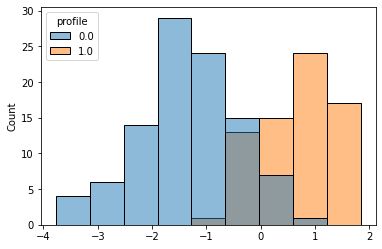

In [116]:
# clf = SVC(kernel='poly', degree=3, C=0.1)
clf = LogisticRegression()
clf.fit(X, y)
print(clf.score(X, y))
sns.histplot(x=clf.decision_function(X), hue=y)
plt.show()

In [117]:
# Feature perturbation
for feature in X.columns:
    tmp_X = X.copy()
    

In [118]:
from sklearn.inspection import permutation_importance


In [119]:
r = permutation_importance(clf, X, y, n_repeats=30, random_state=0)

In [120]:
[col for col in X.columns if '299' in col]

['127-299', '246-299', '250-299', '51-299', '76-299']

In [121]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

87-113  0.035 +/- 0.013
195-258 0.035 +/- 0.015
121-202 0.031 +/- 0.014
41-92   0.026 +/- 0.013
120-258 0.025 +/- 0.008
41-88   0.021 +/- 0.009
44-84   0.020 +/- 0.013
131-243 0.019 +/- 0.009
124-251 0.019 +/- 0.011
50-297  0.018 +/- 0.012
264-280 0.018 +/- 0.011
121-205 0.016 +/- 0.010
250-291 0.016 +/- 0.009
260-287 0.014 +/- 0.006
253-291 0.014 +/- 0.009
80-291  0.014 +/- 0.010
40-88   0.013 +/- 0.013
300-306 0.012 +/- 0.008
37-92   0.011 +/- 0.010
84-289  0.011 +/- 0.004
143-149 0.010 +/- 0.006
117-258 0.010 +/- 0.004
257-288 0.010 +/- 0.009
209-245 0.009 +/- 0.007
65-147  0.009 +/- 0.006
91-285  0.008 +/- 0.008
80-116  0.007 +/- 0.006
70-246  0.005 +/- 0.005


<AxesSubplot:xlabel='87-113', ylabel='195-258'>

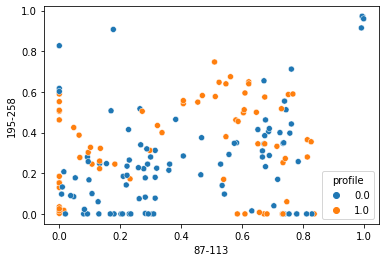

In [122]:
sns.scatterplot(data=X, x='87-113', y='195-258', hue=y)

In [25]:
X

,115-161,117-254,117-258,119-157,121-202,121-205,124-247,124-251,127-299,128-247,...,83-116,84-289,87-113,87-289,91-282,91-285,91-286,128-209,120-258,131-246
0,0.1875,0.4175,0.6800,0.6875,0.5950,0.4675,0.5325,0.2250,0.0025,0.6125,...,0.7525,0.1875,0.6225,0.5150,0.3925,0.7575,0.4300,0.0000,0.0000,0.0
1,0.3875,0.3125,0.4450,0.7775,0.6550,0.3225,0.4675,0.1600,0.0050,0.4550,...,0.7900,0.2475,0.5100,0.6000,0.6150,0.7450,0.5525,0.0025,0.0000,0.0
2,0.2925,0.3700,0.8650,0.6275,0.5800,0.4125,0.6100,0.1825,0.0150,0.7100,...,0.8050,0.2050,0.5250,0.5250,0.5900,0.6200,0.5750,0.0025,0.0000,0.0
3,0.2450,0.1600,0.9325,0.8375,0.3475,0.5625,0.6100,0.2150,0.0050,0.6350,...,0.8250,0.2275,0.2325,0.4200,0.3125,0.1850,0.6625,0.0025,0.0625,0.0
4,0.3950,0.1600,0.8500,0.6800,0.2250,0.3900,0.5975,0.1800,0.0150,0.6550,...,0.7875,0.2150,0.5400,0.5275,0.5575,0.6525,0.6175,0.0025,0.0175,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.1025,0.4625,0.6050,0.7675,0.6250,0.7275,0.7525,0.6950,0.0000,0.6700,...,0.3725,0.2800,0.0000,0.4575,0.0000,0.0000,0.0000,0.0050,0.0000,0.0
171,0.1300,0.3000,0.7000,0.8225,0.6775,0.6500,0.5100,0.7400,0.0000,0.3050,...,0.3800,0.2750,0.0000,0.3850,0.0000,0.0000,0.0000,0.0050,0.0000,0.0
172,0.1225,0.3450,0.6650,0.7300,0.6000,0.6525,0.5225,0.5375,0.0000,0.5550,...,0.4725,0.3600,0.1700,0.4450,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
173,0.1350,0.3475,0.7225,0.7325,0.6425,0.6675,0.5800,0.5950,0.0000,0.6775,...,0.4425,0.1875,0.0000,0.3525,0.0000,0.0000,0.0000,0.0000,0.0000,0.0


In [71]:
from sklearn.random_projection import SparseRandomProjection
from tqdm import tqdm

In [72]:
scores = []

100%|██████████| 100000/100000 [20:11<00:00, 82.53it/s]


In [77]:

clf = SVC()
best_projector = None
best_score = 0
for i in tqdm(range(100000*6)):
    projector = SparseRandomProjection(n_components=2)
    projection = projector.fit_transform(X)
    
    p_df = pd.DataFrame(projection)
    p_df.columns = ['c1', 'c2']
    p_df['profile'] = y.values
    
    clf.fit(projection, y)
    score = clf.score(projection, y)
    
    if score > best_score:
        best_score = score
        best_projector = projector
    scores.append(score)

100%|██████████| 600000/600000 [2:00:12<00:00, 83.19it/s]  


In [79]:
print(best_score)

0.8411764705882353


<AxesSubplot:ylabel='Count'>

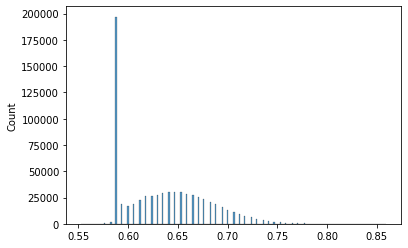

In [80]:
sns.histplot(scores)

In [81]:
projection = best_projector.transform(X)
    
p_df = pd.DataFrame(projection)
p_df.columns = ['c1', 'c2']
p_df['profile'] = y.values

In [83]:
def plot_decission_surface(f1, f2, y, degree=2):
    # fit logistic regression model
    clf = SVC(class_weight='balanced', C=0.5)
    # clf = RandomForestClassifier(max_depth=4)
    # clf = DecisionTreeClassifier(max_depth=4)
    clf.fit(np.stack([f1, f2]).transpose(), y)
    
    score = clf.score(np.stack([f1, f2]).transpose(), y)

    # define meshgrid of points to evaluate decision boundary
    x_min, x_max = f1.min() - 0.5, f1.max() + 0.5
    y_min, y_max = f2.min() - 0.5, f2.max() + 0.5
    h = 0.01  # step size in meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape).astype(int)

    # plot decision boundary and scatterplot of data points
    colors = sns.color_palette()
    plt.contourf(xx, yy, Z, alpha=0.4, colors=colors, )  # fill decision areas with color
    sns.scatterplot(x=f1, y=f2, hue=y)
    plt.show()
    
    return score

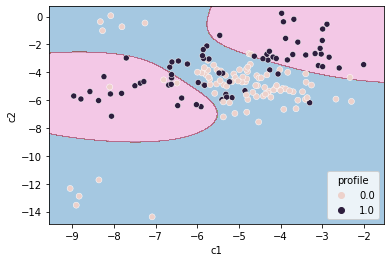

0.8588235294117647

In [84]:
plot_decission_surface(p_df['c1'], p_df['c2'], y, degree=2)

<AxesSubplot:xlabel='c1', ylabel='c2'>

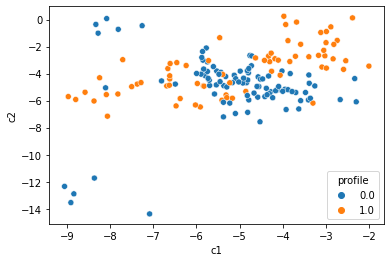

In [82]:
sns.scatterplot(data=p_df, x='c1', y='c2', hue='profile')

In [147]:
best_projector.components_

<2x84 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>